In [285]:
import numpy as np 
import matplotlib.pyplot as plt 
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
import random
import seaborn as sns
import datetime
import pandas as pd
#!pip install sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')
from bs4 import BeautifulSoup
import requests
import json
import time

In [712]:
def get_realtime_info(stock_code, printing=True):
    URL_link = "https://www.citifirst.com.hk/en/data/json/json_realtimedata/code/"+stock_code
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'}
    soup = BeautifulSoup(requests.get(URL_link, headers=headers).content, 'html.parser')

    start_index = str(soup).find("{")
    end_index = str(soup).find("}")
    st = str(soup)[start_index:end_index+1]
    json_str = ""
    for ln in st.split(","):
        if "<" not in ln:
            json_str = json_str + ln + ","
    dic = json.loads(json_str[:-1])

    stock_name, current_time, current_price, current_volume_info = dic['code']+".HK", dic['stimeNoformat'], dic['last'], dic['turnover']
    info = []
    dif = round(float(current_price)-float(dic['lastc']), 2)
    ratio = round(dif/float(dic['lastc'])*100, 2)
    info.append( str(dif) + "\t\t" + str(ratio) + "%" )
    info.append( "open\t\t" + dic['open'] )
    info.append( "high\t\t" + dic['high'] )
    info.append( "low\t\t" + dic['low'] )
    info.append( "turnover\t\t" + dic['turnover'] )
    info.append( "last close\t\t" + dic['lastc'] )
    if printing:
        for sub_info in info:
            print( "\t\t", sub_info )
    return stock_name, current_time, current_price, info, current_volume_info

def calculate_week_number(df_data):
    start_weekday = df_data.index[0].weekday()
    start_date = df_data.index[0]
    week_nums = []
    i = 0
    while i<len(df_data.index):
        cur_date = df_data.index[i]
        cur_week_num = ( int((cur_date- start_date).days) + start_weekday ) // 7
        week_nums.append( cur_week_num )
        i += 1
    df_data['week_num'] = week_nums
    return df_data


# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
    df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
    real_time_str = "data may late for 15 minutes"
    if ".HK" in ticker_name:
        flag = True        
        try:
            stock_name, current_time, current_price, info, current_volume_info = get_realtime_info(ticker_name, False)
            today_date = current_time.strip()[:10]
            today_date = datetime.datetime.strptime(today_date, '%Y-%m-%d')
            if today_date == df_data.index[-1]:  
                print("update real time for today")      
                open_price, high_price, low_price = info[1].split()[1], info[2].split()[1], info[3].split()[1]
                df_data.at[df_data.index[-1], "Open"] = float(open_price)
                df_data.at[df_data.index[-1], "High"] = float(high_price)
                df_data.at[df_data.index[-1], "Low"] = float(low_price)
                df_data.at[df_data.index[-1], "Close"] = float(current_price)
            elif today_date > df_data.index[-1]:
                print("add real time for today", today_date)
                open_price, high_price, low_price = info[1].split()[1], info[2].split()[1], info[3].split()[1]
                print(open_price, high_price, low_price)
                new_row = [float(open_price), float(high_price), float(low_price), float(current_price), float(current_price), 0]
                col_names = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
                df_data = df_data.append(pd.DataFrame([ new_row ],index=[ today_date ],columns=col_names))
            flag = False
            real_time_str = "real time data"
        except:
            df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
            real_time_str = "data may late for 15 minutes"
    print(ticker_name, ":\t", real_time_str)
    df_data = df_data[ ["Open", "High", "Low", "Close", "Volume"] ]
    df_data['Volume_log'] = np.log2(df_data['Volume'])
    df_data['previous_Close'] = df_data['Close'].shift(1)
    df_data['daily_return'] = (df_data['Close']-df_data['previous_Close'])/df_data['previous_Close']
    df_data['overnight_return'] = (df_data['Open']-df_data['previous_Close'])/df_data['previous_Close']
    MA1, MA2 = 5, 20
    df_data['MA1'] = df_data['Close'].rolling(MA1).mean()
    df_data['MA2'] = df_data['Close'].rolling(MA2).mean()
    df_data['weekday'] = df_data.index.weekday
    df_data = calculate_week_number(df_data)   
    return df_data

def merge_stocks(df_data1, df_data2):
    data = []
    i = 0
    while i<len(df_data1):
        target_time = df_data1.index[i]

        j = 0
        while j<len(df_data2):
            ref_time = df_data2.index[j]
            if ref_time>=target_time:
                break
            j += 1
        ref_time = df_data2.index[j-1]
        if ref_time<target_time:
            it1 = df_data1.iloc[i]   
            open1, high1, low1, close1 = it1['Open'], it1['High'], it1['Low'], it1['Close']
            daily_return1 = it1['daily_return']
            volume1 = it1['Volume_log'] # Volume, Volume_log
            target_MA1, target_MA2 = it1['MA1'], it1['MA2']
            it2 = df_data2.iloc[j-1]
            open2, high2, low2, close2 = it2['Open'], it2['High'], it2['Low'], it2['Close']
            daily_return2 = it2['daily_return']
            volume2 = it2['Volume_log'] # Volume, Volume_log
            ref_MA1, ref_MA2 = it2['MA1'], it2['MA2']

            tmp_list = [ target_time, open1, high1, low1, close1, daily_return1, volume1, target_MA1, target_MA2, ref_time, open2, high2, low2, close2, daily_return2, volume2, ref_MA1, ref_MA2 ]
            data.append( tmp_list )
            #print( target_time, ref_time )
        i += 1
    col_names = ['target_time', 'target_open', 'target_high', 'target_low', 'target_close', 'target_return', 'target_volume', 'target_MA1', 'target_MA2',
                'ref_time', 'ref_open', 'ref_high', 'ref_low', 'ref_close', 'ref_return', 'ref_volume', 'ref_MA1', 'ref_MA2']
    df = pd.DataFrame(data, columns = col_names)
    return df

def get_datasets(merged_data, feature_list=['open', 'close', 'high', 'low'], label="close", movement=1):
    data_source = merged_data.copy()
    if movement == 1:
        data_source = data_source[ data_source['ref_return']>0 ]
    elif movement == 0:
        data_source = data_source[ data_source['ref_return']<0 ]

    features = []
    for f in feature_list:
        tmp_list = list( data_source['ref_' + f] )
        features.append( tmp_list )
    # pack features
    packed_features = []
    i = 0
    while i<len(features[0]):
        it = []
        j = 0
        while j<len(features):
            v = features[j][i]
            it.append(v)            
            j += 1
        packed_features.append(it)
        i += 1
    labels = data_source['target_'+label]
    return packed_features, labels

def train_model(train_X, train_y, printing=True):
    model = LinearRegression().fit(train_X, train_y)

    r_sq = model.score(train_X, train_y)
    if printing:
        print(f"coefficient of determination: {r_sq}")
        print(f"intercept: {model.intercept_}\tslope: {model.coef_}")
    return model

def basic_info(df):
    print("mean:\t", df['dif'].mean())
    print("median:\t", df['dif'].median())
    print("std:\t", df['dif'].std())
    print("25%:\t", df['dif'].quantile(0.25))
    print("50%:\t", df['dif'].quantile(0.50))
    print("75%:\t", df['dif'].quantile(0.75))
    return

def error_analyze(train_y, y_pred, printing=True):
    df = pd.DataFrame(columns = ['y_real', 'y_pred'])
    df['y_real'] = train_y
    df['y_pred'] = y_pred
    df['dif'] = (df['y_real'] - df['y_pred'])/df['y_real'] * 100
    df['dif'] = df['dif'].abs()
    if printing:
        basic_info(df)
    return df

In [721]:
# http://www.aastocks.com/tc/usq/market/china-concept-stock.aspx
stocks_info = [
    ('BABA', '9988.HK', 1),
    ('BIDU', '9888.HK', 1),
    ('JD', '9618.HK', 0.5 * 7.8),
    ('MPNGY', '3690.HK', 0.5 * 7.8),
    ('NTES', '9999.HK', 0.2 * 7.8),
	('LI', '2015.HK', 0.5 * 7.8),
	('XPEV', '9868.HK', 0.5*7.8),	
	('BILI', '9626.HK', 1 * 7.8),
	('TCOM', '9961.HK', 1 * 7.8),
	('YUMC', '9987.HK', 1*7.8),
	('EDU', '9901.HK', 0.1*7.8), 
    ('NIO', '9866.HK', 1 * 7.8),
	('ZTO', '2057.HK', 1*7.8),
    ('BEKE', '2423.HK', 0.5*7.8),
    ('ZH', '2390.HK', 3 * 7.8), 
    ('WB', '9898.HK', 1*7.8),
    ('MNSO', '9896.HK', 0.5*7.8),
    ('ZLAB', '9688.HK', 0.5*7.8)
]

OHLC_list = ['open', 'high', 'low', 'close']
daily_prediction = []
daily_real = []

for it in stocks_info[:]:# 
    reference_stock, target_stock, ratio = it
    st, et = "2020-01-01", "2023-04-30"
    print("time range:\t", st, "-", et)
    df_data1 = get_df_data(ticker_name=target_stock, start_time=st, end_time=et)
    print("target stock:\t", target_stock, "\t", len(df_data1))
    df_data2 = get_df_data(ticker_name=reference_stock, start_time=st, end_time=et)
    print("reference stock:\t", reference_stock, "\t", len(df_data2))
        # merge reference-stock & target-stock: target stock (datetime, open, high, low, close), 1-day previous reference stock (datetime, open, high, low, close) 
    merged_data = merge_stocks(df_data1, df_data2)
    print("merged_data:\ttarget_time:\t", merged_data.iloc[0]['target_time'], "\t", merged_data.iloc[-1]['target_time'])
    print("merged_data:\tref_time:\t", merged_data.iloc[0]['ref_time'], "\t", merged_data.iloc[-1]['ref_time'])

    stock_name = reference_stock + "_" + target_stock
    
    points = df_data1.iloc[-1]
    daily_real.append( [stock_name, points['Open'], points['High'], points['Low'], points['Close'], points['previous_Close']] )
    
    info_list = [stock_name]

    for label_name in OHLC_list:
        printing = False
        if printing:
            print(label_name)
        #label_name = "high"
        feature_names = ['open', 'high', 'low', 'close', 'MA1', 'MA2'] # 'open', 'high', 'low', 'close'

        n_days = 60
        movement = 2
        train_X, train_y = get_datasets(merged_data[-n_days:-1], feature_names, label_name, movement)
        train_X = np.array(train_X)
        train_y = np.array(train_y)

        model = train_model(train_X, train_y, printing)

        y_pred = model.predict(train_X)
        df = error_analyze(train_y, y_pred, printing)
        error_mean = df['dif'].mean()
        error_median = df['dif'].median()
        error_75 = df['dif'].quantile(0.75)
        #print( round(error_mean, 2), round(error_median, 2), round(error_75, 2) )

        #test_X, test_y = get_datasets(merged_data[-1:], feature_names, label_name, 2)
        test_X = [ list(df_data2.iloc[-1])[:4] +[ df_data2.iloc[-1]['MA1'], df_data2.iloc[-1]['MA2'] ] ] #  
        test_X = np.array(test_X)
        #test_y = np.array(test_y)

        test_y_pred = model.predict(test_X)
        if printing:
            print(f"reference:\t{test_X} \t predicted:\t{test_y_pred}")
            print()
        info_list.append( test_y_pred[0] )
        info_list.append( error_mean )
        info_list.append( error_median )
    daily_prediction.append( info_list )

time range:	 2020-01-01 - 2023-04-30
[*********************100%***********************]  1 of 1 completed
update real time for today
9988.HK :	 real time data
target stock:	 9988.HK 	 804
[*********************100%***********************]  1 of 1 completed
BABA :	 data may late for 15 minutes
reference stock:	 BABA 	 819
merged_data:	target_time:	 2020-01-03 00:00:00 	 2023-04-04 00:00:00
merged_data:	ref_time:	 2020-01-02 00:00:00 	 2023-04-03 00:00:00
time range:	 2020-01-01 - 2023-04-30
[*********************100%***********************]  1 of 1 completed
update real time for today
9888.HK :	 real time data
target stock:	 9888.HK 	 502
[*********************100%***********************]  1 of 1 completed
BIDU :	 data may late for 15 minutes
reference stock:	 BIDU 	 819
merged_data:	target_time:	 2021-03-23 00:00:00 	 2023-04-04 00:00:00
merged_data:	ref_time:	 2021-03-22 00:00:00 	 2023-04-03 00:00:00
time range:	 2020-01-01 - 2023-04-30
[*********************100%*********************

In [725]:
###
col_names = [
            'stock-name', 
            'open_predicted', 'open_error1%', 'open_error2%',
            'high_predicted', 'high_error1%', 'high_error2%',
            'low_predicted', 'low_error1%', 'low_error2%',
            'close_predicted', 'close_error1%', 'close_error2%'
            ]
info_df = pd.DataFrame(daily_prediction, columns=col_names)
info_df

col_names = ['stock-name', 'open', 'high', 'low', 'close', 'previous_Close']
real_df = pd.DataFrame(daily_real, columns=col_names)
real_df['daily_return'] = (real_df['close'] - real_df['previous_Close'])/real_df['previous_Close']*100
real_df

# http://www.aastocks.com/tc/usq/market/china-concept-stock.aspx
stocks_info = [
    ('BABA', '9988.HK', 1),
    ('BIDU', '9888.HK', 1),
    ('JD', '9618.HK', 0.5 * 7.8),
    ('MPNGY', '3690.HK', 0.5 * 7.8),
    ('NTES', '9999.HK', 0.2 * 7.8),
	('LI', '2015.HK', 0.5 * 7.8),
	('XPEV', '9868.HK', 0.5*7.8),	
	('BILI', '9626.HK', 1 * 7.8),
	('TCOM', '9961.HK', 1 * 7.8),
	('YUMC', '9987.HK', 1*7.8),
	('EDU', '9901.HK', 0.1*7.8), 
    ('NIO', '9866.HK', 1 * 7.8),
	('ZTO', '2057.HK', 1*7.8),
    ('BEKE', '2423.HK', 0.5*7.8),
    ('ZH', '2390.HK', 3 * 7.8), 
    ('WB', '9898.HK', 1*7.8),
    ('MNSO', '9896.HK', 0.5*7.8),
    ('ZLAB', '9688.HK', 0.5*7.8)
]

close_list = []
realtime_priceChange = []
realtime_dailyReturn = []
for it in stocks_info[:]:
    ref_code, target_code, ratio = it
    stock_code = target_code[:4] # 9988, 9998, 3690
    stock_name, current_time, current_price, info, current_volume_info = get_realtime_info(stock_code, False)
    price_change, price_dif = info[0].split()
    price_change, price_dif = float(price_change), float(price_dif.replace("%", ""))
    price_change, price_dif
    #print( ref_code, target_code, current_time, current_price, info[0], sep="\t" )
    close_list.append( float(current_price) )
    realtime_priceChange.append( price_change )
    realtime_dailyReturn.append( price_dif )

tmp_df = info_df[ ['stock-name', 'close_predicted', 'close_error1%', 'close_error2%'] ].copy()
tmp_df['close_error3%'] = (tmp_df['close_error1%'] + tmp_df['close_error2%'])/2
tmp_df['close_error%'] = tmp_df['close_error1%']
tmp_df['close_real'] = close_list
tmp_df['pred_real_dif%'] = (tmp_df['close_predicted'] - tmp_df['close_real'])/tmp_df['close_predicted']*100
tmp_df['pred_real_dif%'] = tmp_df['pred_real_dif%'].abs()
tmp_df['Correct'] = tmp_df['close_error%'] >= tmp_df['pred_real_dif%']

tmp_df['price_change'] = realtime_priceChange
tmp_df['previous_Close'] = tmp_df['close_real'] - tmp_df['price_change']

tmp_df['daily_return%'] = realtime_dailyReturn
col_names = [
    'stock-name'
    , 'close_predicted', 'close_error%'
    , 'close_real', 'pred_real_dif%'
    , 'Correct'
    , 'price_change', 'previous_Close', 'daily_return%'
    #,'close_error1%', 'close_error2%', 'close_error3%'
    ]
# , 'close_error1%': 2, 'close_error2%': 2, 'close_error3%': 2
tmp_df = tmp_df[ col_names ]
round_dic = {'close_predicted': 2, 'close_error%': 2, 'close_real': 2, 'pred_real_dif%': 2, 'previous_Close':2, 'daily_return%':2 }
tmp_df.round(round_dic)

,stock-name,close_predicted,close_error%,close_real,pred_real_dif%,Correct,price_change,previous_Close,daily_return%
0,BABA_9988.HK,96.73,1.46,95.65,1.12,True,-2.90,98.55,-2.94
1,BIDU_9888.HK,147.31,2.11,146.80,0.35,True,1.20,145.60,0.82
2,JD_9618.HK,165.39,1.63,164.00,0.84,True,-3.27,167.27,-1.95
3,MPNGY_3690.HK,137.37,1.72,133.90,2.53,False,-6.10,140.00,-4.36
4,NTES_9999.HK,140.77,1.61,140.90,0.10,True,2.20,138.70,1.59
5,LI_2015.HK,95.59,2.03,93.95,1.71,True,-3.50,97.45,-3.59
6,XPEV_9868.HK,42.99,2.35,41.45,3.57,False,-2.90,44.35,-6.54
7,BILI_9626.HK,181.84,2.20,171.00,5.96,False,-10.10,181.10,-5.58
8,TCOM_9961.HK,292.82,1.28,294.00,0.40,True,-0.60,294.60,-0.20
9,YUMC_9987.HK,501.29,1.30,494.20,1.41,False,-2.00,496.20,-0.40


In [724]:
info_df[ ['stock-name', 'open_predicted', 'open_error1%', 'open_error2%'] ]
info_df[ ['stock-name', 'high_predicted', 'high_error1%', 'high_error2%'] ]
info_df[ ['stock-name', 'low_predicted', 'low_error1%', 'low_error2%'] ]
info_df[ ['stock-name', 'close_predicted', 'close_error1%', 'close_error2%'] ]
info_df

,stock-name,open_predicted,open_error1%,open_error2%,high_predicted,high_error1%,high_error2%,low_predicted,low_error1%,low_error2%,close_predicted,close_error1%,close_error2%
0,BABA_9988.HK,96.230498,0.562845,0.511131,97.955838,1.216451,0.934635,94.449027,0.934930,0.777316,96.734361,1.464233,1.165377
1,BIDU_9888.HK,147.213288,0.732940,0.488930,150.704468,1.842706,1.352319,143.653504,1.311628,1.178848,147.309413,2.111037,1.504971
2,JD_9618.HK,165.847763,0.761201,0.576397,167.883105,1.157214,1.038806,162.046940,1.226114,1.072302,165.389045,1.634919,1.329577
3,MPNGY_3690.HK,137.858172,0.790038,0.583504,140.877129,1.286090,1.079152,134.221926,1.339224,1.012810,137.369557,1.718570,1.533195
4,NTES_9999.HK,140.880205,0.781328,0.608158,143.047458,1.164023,0.896342,138.611609,0.939684,0.884191,140.765761,1.614494,1.494769
5,LI_2015.HK,95.837099,0.755710,0.663295,97.617959,1.468006,1.121033,93.256240,1.522175,1.402099,95.585360,2.034095,1.792695
6,XPEV_9868.HK,43.361694,0.763336,0.596741,43.836302,1.642612,1.321496,41.784450,1.505477,0.997796,42.985742,2.352276,2.046455
7,BILI_9626.HK,178.508217,0.793394,0.569482,185.236170,1.744558,1.556165,175.886866,1.469857,1.308982,181.839892,2.198893,1.850206
8,TCOM_9961.HK,294.600906,0.757903,0.638150,298.995152,0.908045,0.559011,289.285218,0.914519,0.754581,292.821353,1.281533,0.995086
9,YUMC_9987.HK,501.137289,0.911798,0.741533,508.047041,0.843563,0.805382,495.262908,0.849571,0.797683,501.292266,1.298083,1.132953


In [539]:
def return2str(df_data):
    daily_return = list(df_data['daily_return'])
    st = ""
    i = 1
    while i<len(daily_return):
        v = daily_return[i]
        if v > 0:
            st = st + "+1"
        else:
            st = st + "-1"
        i += 1
    return st

def find_pattern(st, ptn):
    c1 = st.count(ptn+"+1")
    c2 = st.count(ptn+"-1")
    total = c1 + c2
    r1 = round(c1/total*100, 2)
    print("rise %:\t", c1, "\t", r1, "%")
    r2 = round(c2/total*100, 2)
    print("fall %:\t", c2, "\t", r2, "%")
    return c1, c2



def weekly_data(df_data):
    dic = {}
    for w in list(set(df_data['week_num'])):
        sub_df = df_data[ df_data['week_num']==w ]

        weekday_list, dailyreturn_list = sub_df['weekday'], sub_df['daily_return']
        key, value = "", ""
        i = 0
        while i<len(weekday_list):
            key = key + str(weekday_list[i])
            if dailyreturn_list[i]>0:
                value = value + "+"
            else:
                value = value + "-"
            i += 1

        L = len(sub_df)
        if L not in dic:
            dic[L] = []
        
        dic[L].append( (key, value) )
    return dic

def match_week_pattern(week_dic, ptn1, ptn2):
    tmp_dic = {}
    L = len(ptn1)
    for it in week_dic[L]:
        k, v = it
        if k==ptn1 and v.startswith(ptn2):
            st = v[:len(ptn2)+1]
            if st not in tmp_dic:
                tmp_dic[st] = 1
            else:
                tmp_dic[st] += 1
    return tmp_dic

df_data = get_df_data('9901.HK', "2020-02-01", "2023-04-30")
df_data = df_data[-100:]
df_data.tail()

st = return2str(df_data)
ptn = "-1-1"
print(st)
c1, c2 = find_pattern(st, ptn)
print(c1, c2)


week_dic = weekly_data(df_data)
ptn1, ptn2 = "01234", "--"
tmp_dic = match_week_pattern(week_dic, ptn1, ptn2)
tmp_dic

[*********************100%***********************]  1 of 1 completed
update real time for today
9901.HK :	 real time data
-1-1+1-1+1-1-1+1+1-1-1+1-1-1+1+1-1+1+1-1-1+1+1-1-1+1-1+1+1+1+1+1-1-1-1+1-1+1-1+1+1+1+1-1+1+1+1-1+1+1-1-1-1+1+1+1-1-1-1+1+1-1-1+1-1+1-1+1-1-1+1-1-1-1+1+1+1-1-1-1+1+1+1-1-1+1-1-1+1+1+1+1-1+1+1-1-1-1+1
rise %:	 16 	 72.73 %
fall %:	 6 	 27.27 %
16 6


{'--+': 3, '---': 1}

In [563]:
df_data

,Open,High,Low,Close,Volume,Volume_log,previous_Close,daily_return,overnight_return,MA1,MA2,weekday,week_num
Date,,,,,,,,,,,,,
2022-11-08,23.250000,23.700001,22.650000,23.50,4170940,21.991941,23.10,0.017316,0.006493,22.10,19.2675,1,104
2022-11-09,22.850000,23.250000,21.400000,22.00,4391642,22.066329,23.50,-0.063830,-0.027660,22.33,19.4485,2,104
2022-11-10,21.049999,21.400000,20.500000,20.60,2746780,21.389310,22.00,-0.063636,-0.043182,22.37,19.5915,3,104
2022-11-11,21.299999,22.299999,20.500000,22.15,3983500,21.925605,20.60,0.075243,0.033981,22.27,19.7830,4,104
2022-11-14,20.299999,20.750000,19.219999,19.60,8098708,22.949260,22.15,-0.115124,-0.083521,21.57,19.8570,0,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,30.950001,32.000000,30.700001,31.00,1929384,20.879709,29.35,0.056218,0.054514,30.02,30.4350,2,124
2023-03-30,31.100000,31.200001,30.600000,30.90,1496026,20.512704,31.00,-0.003226,0.003226,30.12,30.3725,3,124
2023-03-31,30.900000,31.450001,30.250000,30.60,1799632,20.779270,30.90,-0.009709,0.000000,30.15,30.1800,4,124


In [574]:
# http://www.aastocks.com/tc/usq/market/china-concept-stock.aspx
stocks_info = [
    ('BABA', '9988.HK', 1),
    ('BIDU', '9888.HK', 1),
    ('JD', '9618.HK', 0.5 * 7.8),
    ('MPNGY', '3690.HK', 0.5 * 7.8),
    ('NTES', '9999.HK', 0.2 * 7.8),
	('LI', '2015.HK', 0.5 * 7.8),
	('XPEV', '9868.HK', 0.5*7.8),	
	('BILI', '9626.HK', 1 * 7.8),
	('TCOM', '9961.HK', 1 * 7.8),
	('YUMC', '9987.HK', 1*7.8),
    ('NIO', '9866.HK', 1 * 7.8),
	('EDU', '9901.HK', 0.1*7.8), 
	('ZTO', '2057.HK', 1*7.8),
    ('BEKE', '2423.HK', 0.5*7.8),
    ('HTHT', '1179.HK', 0.1*7.8),
    #('TENCENT', '0700.HK', 1*7.8)
    ('TME', '1698.HK', 0.5*7.8),	
    ('ZH', '2390.HK', 3 * 7.8),    
    ('QFIN', '3660.HK', 0.5*7.8),
    ('TUYA', '2391.HK', 1*7.8),
    ('ZLAB', '9688.HK', 0.5*7.8),
    ('ATHM', '2518.HK', 0.5*7.8),
    ('KC', '3896.HK', 0.5*7.8),
    ('WB', '9898.HK', 1*7.8),
    ('MNSO', '9896.HK', 0.5*7.8),
    ('GDS', '9698.HK', 1)
]


stocks_df = pd.DataFrame() # daily_real, columns=col_names

i = 0
while i<len(stocks_info):
    name1, stock_code1, _ = stocks_info[i]
    #stock_code1, name1 = stocks_info[i]
    st, et = "2022-06-01", "2023-03-31"
    it_df = get_df_data(stock_code1, st, et)
    stocks_df[name1] = it_df['Close']

    """it_df['day_turnover'] = (it_df['Open']+it_df['High']+it_df['Low']+it_df['Close'])/4 * it_df['Volume']
    mean_turnover, median_turnover = it_df['day_turnover'].mean(), it_df['day_turnover'].median()
    mean_turnover = round(mean_turnover/(1000*1000), 2)
    median_turnover = round(median_turnover/(1000*1000), 2)
    print( name1, stock_code1, "\t\t", mean_turnover, median_turnover )"""

    i += 1

stocks_df
stocks_df.corr()

[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
96.15 96.45 93.70
9988.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
145.60 147.30 143.10
9888.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
165.00 165.50 161.00
9618.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
136.30 137.70 132.00
3690.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
141.60 141.60 139.10
9999.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
add real time for today 2023-04-04 00:00:00
96.40 96.40 92.10
2015.HK :	 real time data
[*********************100%********************

,BABA,BIDU,JD,MPNGY,NTES,LI,XPEV,BILI,TCOM,YUMC,...,TME,ZH,QFIN,TUYA,ZLAB,ATHM,KC,WB,MNSO,GDS
BABA,1.000000,0.784826,0.744871,0.628355,0.769672,0.690667,0.579227,0.877070,0.226385,0.164899,...,0.841885,0.886677,0.819193,0.844131,0.388843,0.849115,0.012826,0.906220,0.396901,0.829829
BIDU,0.784826,1.000000,0.445066,0.383594,0.898871,0.719623,0.531869,0.837933,0.271840,0.268136,...,0.754961,0.717030,0.473756,0.733053,0.429500,0.752941,0.309952,0.875139,0.489639,0.775010
JD,0.744871,0.445066,1.000000,0.914766,0.555921,0.644360,0.653799,0.695438,-0.152262,-0.202192,...,0.510820,0.600958,0.427305,0.370105,0.461364,0.743582,-0.158336,0.639929,-0.213974,0.790384
MPNGY,0.628355,0.383594,0.914766,1.000000,0.531897,0.683302,0.758763,0.625346,-0.326983,-0.386018,...,0.287502,0.504418,0.223002,0.205269,0.264373,0.669434,0.008552,0.569999,-0.406028,0.786289
NTES,0.769672,0.898871,0.555921,0.531897,1.000000,0.762506,0.668820,0.803018,0.005232,0.006527,...,0.704411,0.683888,0.610096,0.654329,0.386103,0.804026,0.342203,0.848005,0.275447,0.854264
LI,0.690667,0.719623,0.644360,0.683302,0.762506,1.000000,0.937543,0.679160,-0.297199,-0.324652,...,0.596627,0.578396,0.538645,0.474451,0.343070,0.768547,0.101100,0.690220,-0.128609,0.903089
XPEV,0.579227,0.531869,0.653799,0.758763,0.668820,0.937543,1.000000,0.567655,-0.536693,-0.562386,...,0.232527,0.488912,0.170125,0.253768,0.161832,0.674206,0.516568,0.556329,-0.431772,0.865150
BILI,0.877070,0.837933,0.695438,0.625346,0.803018,0.679160,0.567655,1.000000,0.285256,0.224155,...,0.938383,0.783115,0.631051,0.770553,0.390666,0.794958,0.265977,0.855615,0.408368,0.838257
TCOM,0.226385,0.271840,-0.152262,-0.326983,0.005232,-0.297199,-0.536693,0.285256,1.000000,0.953818,...,0.933706,0.251934,0.639445,0.610547,0.192138,0.033237,0.082244,0.232117,0.919307,-0.176914
YUMC,0.164899,0.268136,-0.202192,-0.386018,0.006527,-0.324652,-0.562386,0.224155,0.953818,1.000000,...,0.887009,0.175454,0.352374,0.564516,0.239620,0.011931,0.340117,0.200585,0.924240,-0.223694


In [575]:

def relative_values(y_list, offset_v=0):
    tmp_list = []
    base_value = 1
    for r in y_list:
        base_value = base_value * (1+r)
        tmp_list.append( base_value*100+offset_v )
    return tmp_list

positive_corr = [
    [('BABA', '9988.HK', 1),	('WB', '9898.HK', 1*7.8),	('ZH', '2390.HK', 3 * 7.8),	('BILI', '9626.HK', 1 * 7.8)],
    [('BIDU', '9888.HK', 1), 	('NTES', '9999.HK', 0.2 * 7.8),	('WB', '9898.HK', 1*7.8)],
    [('JD', '9618.HK', 0.5 * 7.8), 	('MPNGY', '3690.HK', 0.5 * 7.8)],
    [('LI', '2015.HK', 0.5 * 7.8), 	('XPEV', '9868.HK', 0.5*7.8),	('GDS', '9698.HK', 1)],
    [('XPEV', '9868.HK', 0.5*7.8), 	('NIO', '9866.HK', 1 * 7.8)],
    [('BILI', '9626.HK', 1 * 7.8), 	('TME', '1698.HK', 0.5*7.8)],
    [('TCOM', '9961.HK', 1 * 7.8), 	('YUMC', '9987.HK', 1*7.8),	('HTHT', '1179.HK', 0.1*7.8),	('TME', '1698.HK', 0.5*7.8),	('MNSO', '9896.HK', 0.5*7.8)],
    [('YUMC', '9987.HK', 1*7.8),		('EDU', '9901.HK', 0.1*7.8), ('HTHT', '1179.HK', 0.1*7.8),	('TME', '1698.HK', 0.5*7.8),	('MNSO', '9896.HK', 0.5*7.8)],
    [('EDU', '9901.HK', 0.1*7.8),	('TME', '1698.HK', 0.5*7.8),	('MNSO', '9896.HK', 0.5*7.8)],
    [('HTHT', '1179.HK', 0.1*7.8),		('TME', '1698.HK', 0.5*7.8),	('MNSO', '9896.HK', 0.5*7.8)],
]

negative_corr = [
    [('NIO', '9866.HK', 1 * 7.8),	('EDU', '9901.HK', 0.1*7.8),	('MNSO', '9896.HK', 0.5*7.8)]
]






BABA and BILI :	 0.877
[*********************100%***********************]  1 of 1 completed
update real time for today
9988.HK :	 real time data
[*********************100%***********************]  1 of 1 completed
update real time for today
9626.HK :	 real time data


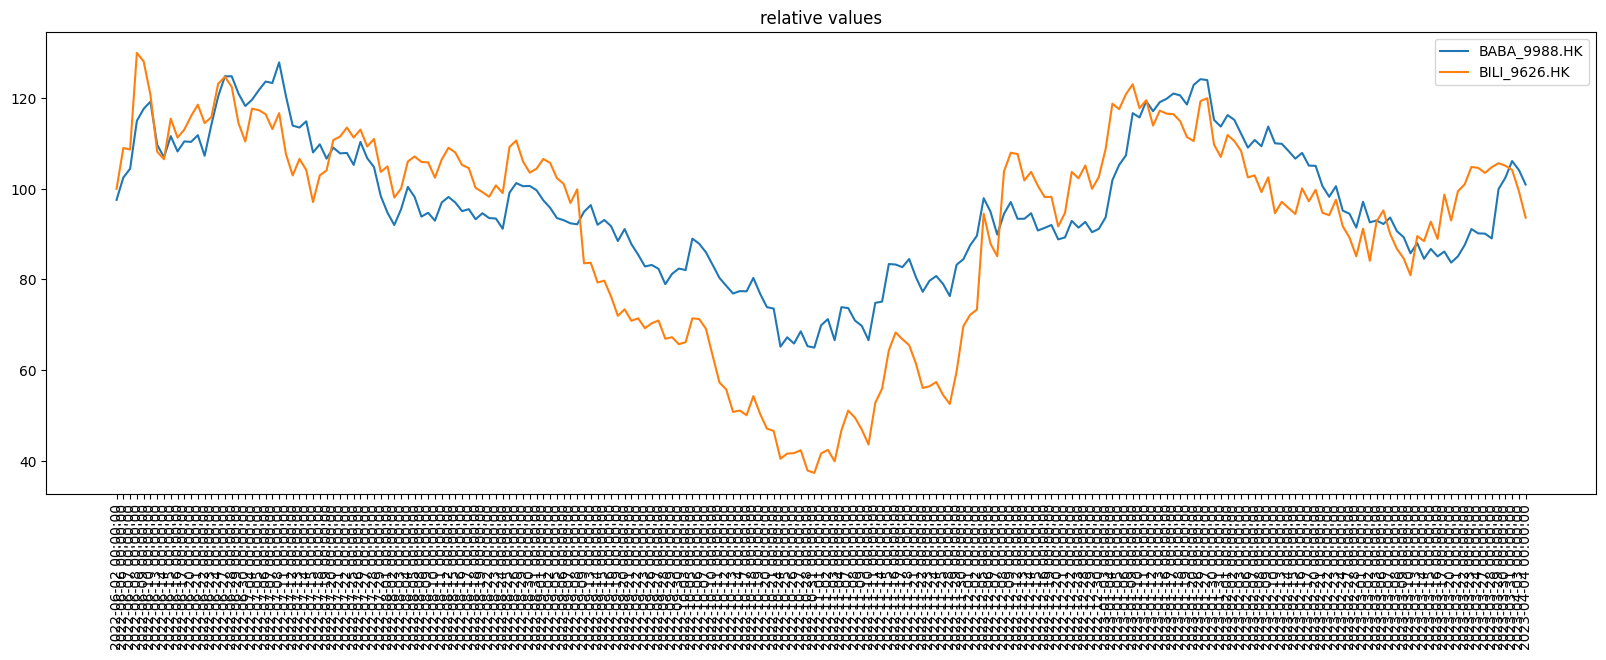

In [596]:
corr_df = stocks_df.corr()

stocks_info = [('BABA', '9988.HK', 1), 	('BILI', '9626.HK', 1 * 7.8)]
st, et = "2022-06-01", "2023-04-30"

stock_name1, stock_code1, _ = stocks_info[0]
stock_name2, stock_code2, _ = stocks_info[1]

corr_score = corr_df[ corr_df.index==stock_name1 ][stock_name2]
corr_score = list(corr_score)[0]
print( stock_name1, "and", stock_name2, ":\t", round(corr_score, 3) )



it_df1 = get_df_data(stock_code1, st, et)
it_df2 = get_df_data(stock_code2, st, et)

y1 = relative_values(list(it_df1['daily_return'])[1:], 0)
y2 = relative_values(list(it_df2['daily_return'])[1:], 0)
x_label = list(it_df1.index)[1:]
x_list = list( range(len(y1)) )

plt.figure(figsize=(20, 6))
plt.plot(x_list, y1 , label=stock_name1+"_"+stock_code1)  # Plot the chart
plt.plot(x_list, y2 , label=stock_name2+"_"+stock_code2)  # Plot the chart
#addlabels(x_list, y_list, 0.05, 0.05)
plt.title("relative values")
plt.xticks(x_list, x_label, rotation=90)
plt.legend()
plt.show()  # display

In [189]:
st, et = "2022-10-01", "2023-04-30"
df_data1 = get_df_data('3660.HK', st, et)
df_data1.tail(15)


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,previous_Close,daily_return,overnight_return,Volume_log,MA1,MA2,weekday,week_num
Date,,,,,,,,,,,,,
2023-03-10,75.000000,75.000000,69.000000,69.949997,4250,75.000000,-0.067333,0.000000,12.053247,77.150000,82.550000,4,14
2023-03-13,69.949997,70.150002,68.199997,69.699997,21600,69.949997,-0.003574,0.000000,14.398744,74.289999,81.687500,0,15
2023-03-14,68.000000,68.000000,64.250000,64.949997,26800,69.699997,-0.068149,-0.024390,14.709945,71.099998,80.647499,1,15
2023-03-15,68.000000,68.750000,66.900002,67.199997,4650,64.949997,0.034642,0.046959,12.183015,69.359998,79.814999,2,15
2023-03-16,66.550003,67.449997,63.000000,65.300003,10150,67.199997,-0.028274,-0.009673,13.309192,67.419998,78.725000,3,15
2023-03-17,66.000000,67.300003,65.250000,65.949997,16700,65.300003,0.009954,0.010720,14.027560,66.619998,77.839999,4,15
2023-03-20,66.900002,66.900002,63.099998,63.349998,5700,65.949997,-0.039424,0.014405,12.476746,65.349998,76.819999,0,16
2023-03-21,67.699997,70.300003,65.599998,70.300003,4450,63.349998,0.109708,0.068666,12.119590,66.420000,76.009999,1,16
2023-03-22,72.150002,72.150002,70.500000,70.800003,4050,70.300003,0.007112,0.026316,11.983706,67.140001,75.512500,2,16
